In [1]:
library(data.table)
library(ggplot2)
theme_set(theme_bw())

Warning message:
“package ‘data.table’ was built under R version 4.2.3”
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”


In [2]:
setwd('~/m/bacterial_dating/19_coherent_prediction_workflow')

In [3]:
# Read cv probabities of the 2-class predictions
system('ls -d data/*.cv_data/*csv |grep -v new_class > data/cv_data_files.txt')
files = fread('data/cv_data_files.txt', header=F)
d1 = files[grep('Perceptron', invert = T, V1),fread(input=V1, header=T, sep='\t', colClasses=list(double='y_actual')), by=V1]
setnames(d1, 'probability_0', 'prob_anaerobe')
setnames(d1, 'probability_1', 'prob_aerobe')
d2 = files[grep('Perceptron', V1),fread(input=V1, header=T, sep='\t', colClasses=list(double=c('y_actual','false_negative_rate','false_positive_rate'))), by=V1]

In [4]:
d2[, prob_anaerobe := -1]
d2[, prob_aerobe := -1]
d = rbind(d1, d2)
dim(d)
d[1:3]

[1] 5092920       9

V1,prob_anaerobe,prob_aerobe,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor
<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.0,AdaBoostClassifier
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.1,AdaBoostClassifier
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4853535,0.5146465,1,GB_GCA_000934545.1,1,0,0.2,AdaBoostClassifier


In [5]:
d[, dataset := gsub('data/(.+).csv.cv_data/.*', '\\1', V1)]
d[1:3]

V1,prob_anaerobe,prob_aerobe,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor,dataset
<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.0,AdaBoostClassifier,bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.1,AdaBoostClassifier,bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4853535,0.5146465,1,GB_GCA_000934545.1,1,0,0.2,AdaBoostClassifier,bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos


In [6]:
# bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.csv
# bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.csv
# bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.apply_respiration_gene_exclusion.csv
# bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.apply_respiration_gene_set_aerobic.csv
# bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_exclusion.csv
# bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_set_aerobic.csv
d[dataset == 'bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos', dataset2 := '1=anaerobe_vs_rest']
d[dataset == 'bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos', dataset2 := '2=anaerobe_vs_aerobe']
d[dataset == 'bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.apply_respiration_gene_exclusion', dataset2 := '3=anaerobe_vs_aerobe_resp_exclude']
d[dataset == 'bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.with_cyanos.apply_respiration_gene_set_aerobic', dataset2 := '4=anaerobe_vs_aerobe_resp_aerobic']
d[dataset == 'bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_exclusion', dataset2 := '5=anaerobe_vs_rest_resp_exclude']
d[dataset == 'bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_set_aerobic', dataset2 := '6=anaerobe_vs_rest_resp_aerobic']
data.table(table(d$dataset2))
d[1:3]

V1,N
<chr>,<int>
1=anaerobe_vs_rest,824544
2=anaerobe_vs_aerobe,758232
3=anaerobe_vs_aerobe_resp_exclude,591552
4=anaerobe_vs_aerobe_resp_aerobic,705312
5=anaerobe_vs_rest_resp_exclude,713952
6=anaerobe_vs_rest_resp_aerobic,824544


V1,prob_anaerobe,prob_aerobe,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor,dataset,dataset2
<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.0,AdaBoostClassifier,bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos,NA
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.1,AdaBoostClassifier,bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos,NA
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos.csv.cv_data/prediction_probabilities_AdaBoostClassifier_0.csv,0.4853535,0.5146465,1,GB_GCA_000934545.1,1,0,0.2,AdaBoostClassifier,bacdive_scrape_20230315.json.parsed.anaerobe_vs_aerobe.no_cyanos,NA


In [7]:
d[, V1 := NULL]
d[, dataset := NULL]
setnames(d, 'dataset2', 'dataset')
d[1:3]

prob_anaerobe,prob_aerobe,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor,dataset
<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.0,AdaBoostClassifier,NA
0.4885685,0.5114315,1,GB_GCA_000934545.1,1,0,0.1,AdaBoostClassifier,NA
0.4853535,0.5146465,1,GB_GCA_000934545.1,1,0,0.2,AdaBoostClassifier,NA


In [8]:
accuracies = d[grep('Isotonic',predictor,invert=T)][grep('Sigmoid',predictor,invert=T)][,.(
    tp = sum(prediction==1 & y_actual==1),
    tn = sum(prediction==0 & y_actual==0),
    fp = sum(prediction==1 & y_actual==0),
    fn = sum(prediction==0 & y_actual==1)
), by=list(predictor, false_negative_rate, false_positive_rate, dataset)]
accuracies[, accuracy := (tp+tn)/(tp+tn+fp+fn)]
accuracies[1:3]

predictor,false_negative_rate,false_positive_rate,dataset,tp,tn,fp,fn,accuracy
<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<dbl>
AdaBoostClassifier,0,0.0,NA,1479,780,48,36,0.9641485
AdaBoostClassifier,0,0.1,NA,1477,770,58,38,0.9590269
AdaBoostClassifier,0,0.2,NA,1470,761,67,45,0.9521980


# Overall accuracies

In [9]:
overall_accuracies = accuracies[, .(accuracy_overall=mean(accuracy)*100), by=list(predictor)][order(-accuracy_overall)]
overall_accuracies

predictor,accuracy_overall
<chr>,<dbl>
XGBoost,96.63516
LogisticRegression,96.02807
GradientBoosting,95.69549
Perceptron,95.34704
RandomForest,94.73960
AdaBoostClassifier,94.16550
ExtraTrees,94.01080
GaussianNB,82.31894


# Plot accuracy with increasing removal of gene families (false negative rate)

In [10]:
dataset_names = sort(unique(d$dataset))
dataset_names

[1] "1=anaerobe_vs_rest"                "2=anaerobe_vs_aerobe"             
[3] "3=anaerobe_vs_aerobe_resp_exclude" "4=anaerobe_vs_aerobe_resp_aerobic"
[5] "5=anaerobe_vs_rest_resp_exclude"   "6=anaerobe_vs_rest_resp_aerobic"

In [11]:
# Order the predictors by accuracy
accuracies[, predictor := factor(predictor, levels=overall_accuracies$predictor)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


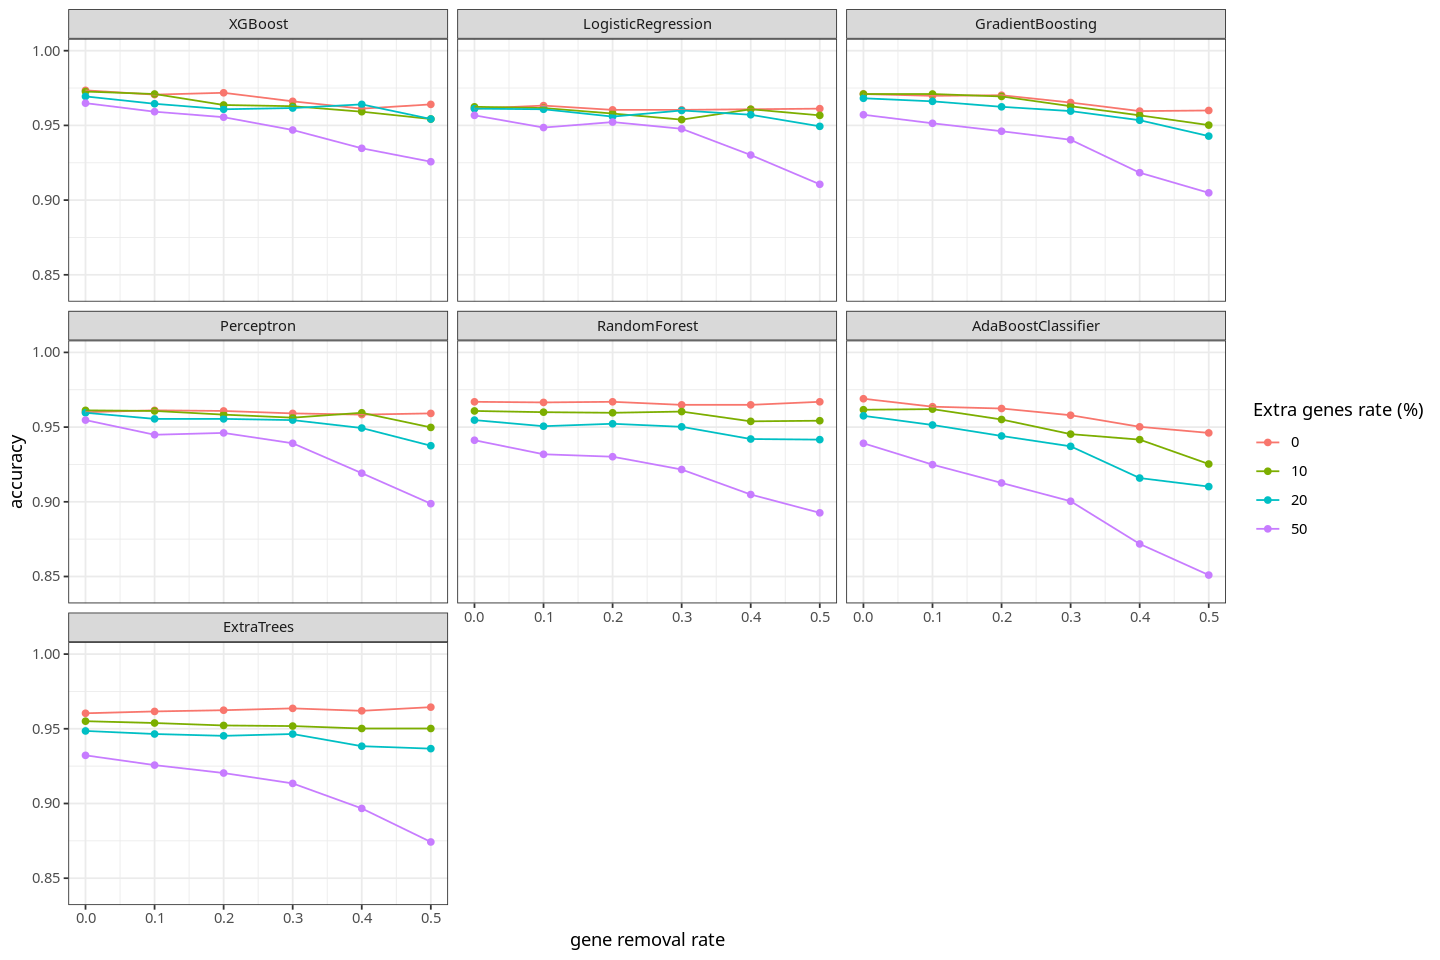

In [12]:
options(repr.plot.width=12, repr.plot.height=8)

qplot(data=accuracies[dataset=='2=anaerobe_vs_aerobe'][grep('Isotonic',predictor,invert=T)][grep('Sigmoid',predictor,invert=T)][grep('GaussianNB',predictor,invert=T)][false_positive_rate %in% c(0,0.1,0.2,0.5)], false_negative_rate, accuracy, ylim=c(0.84,1), xlab='gene removal rate', colour=factor(false_positive_rate*100))+geom_line()+facet_wrap(~predictor)+labs(colour='Extra genes rate (%)')
ggsave('figures/anaerobe_vs_aerobe.accuracy_vs_gene_removal_rate.svg', width=12, height=8)

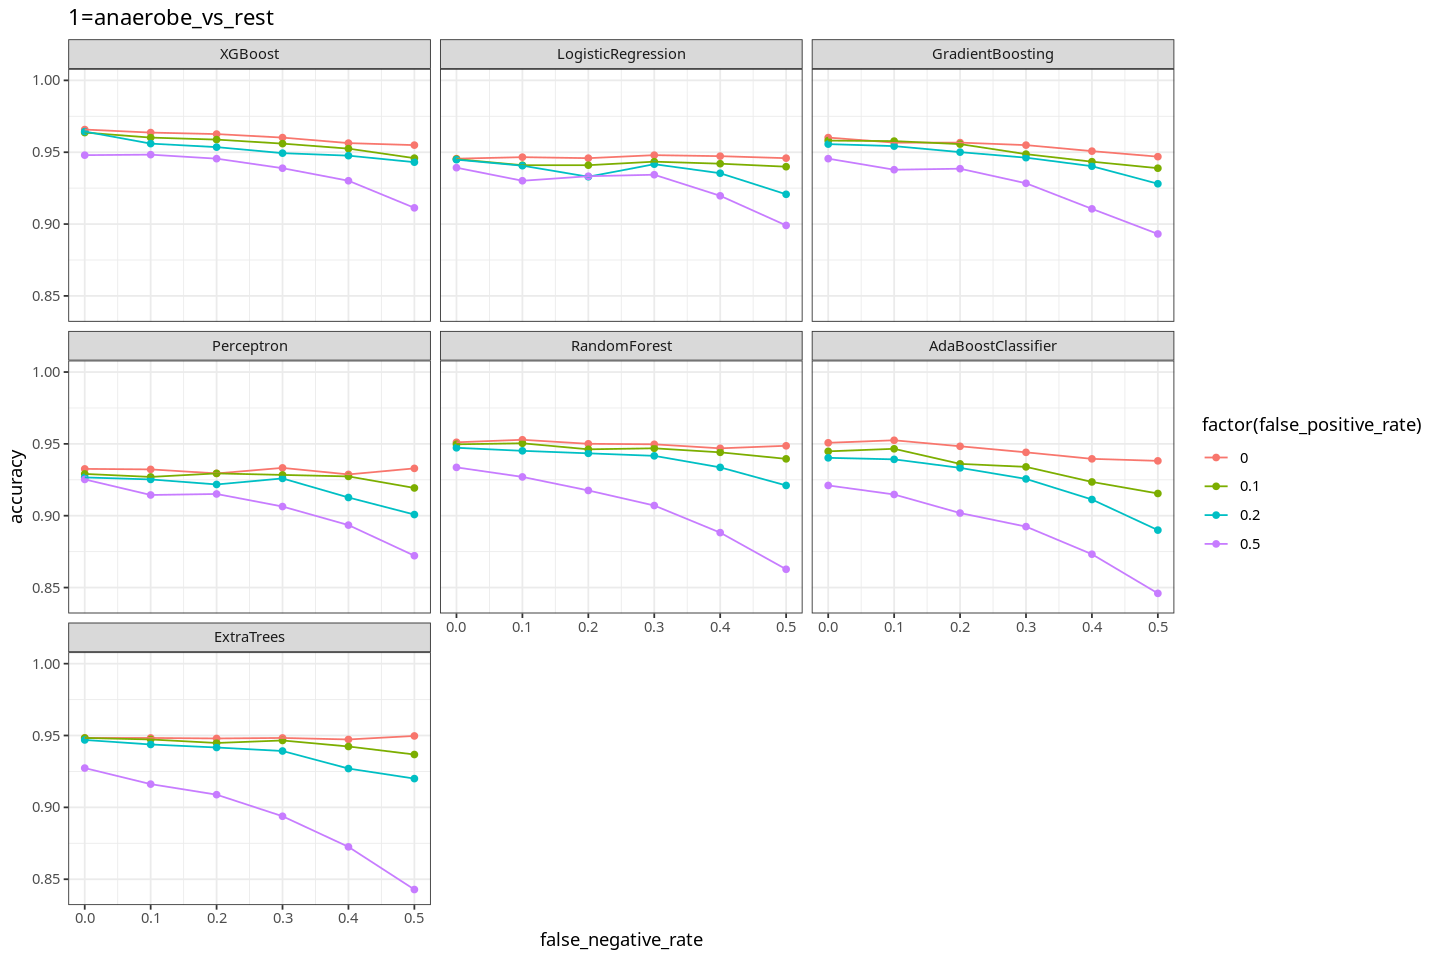

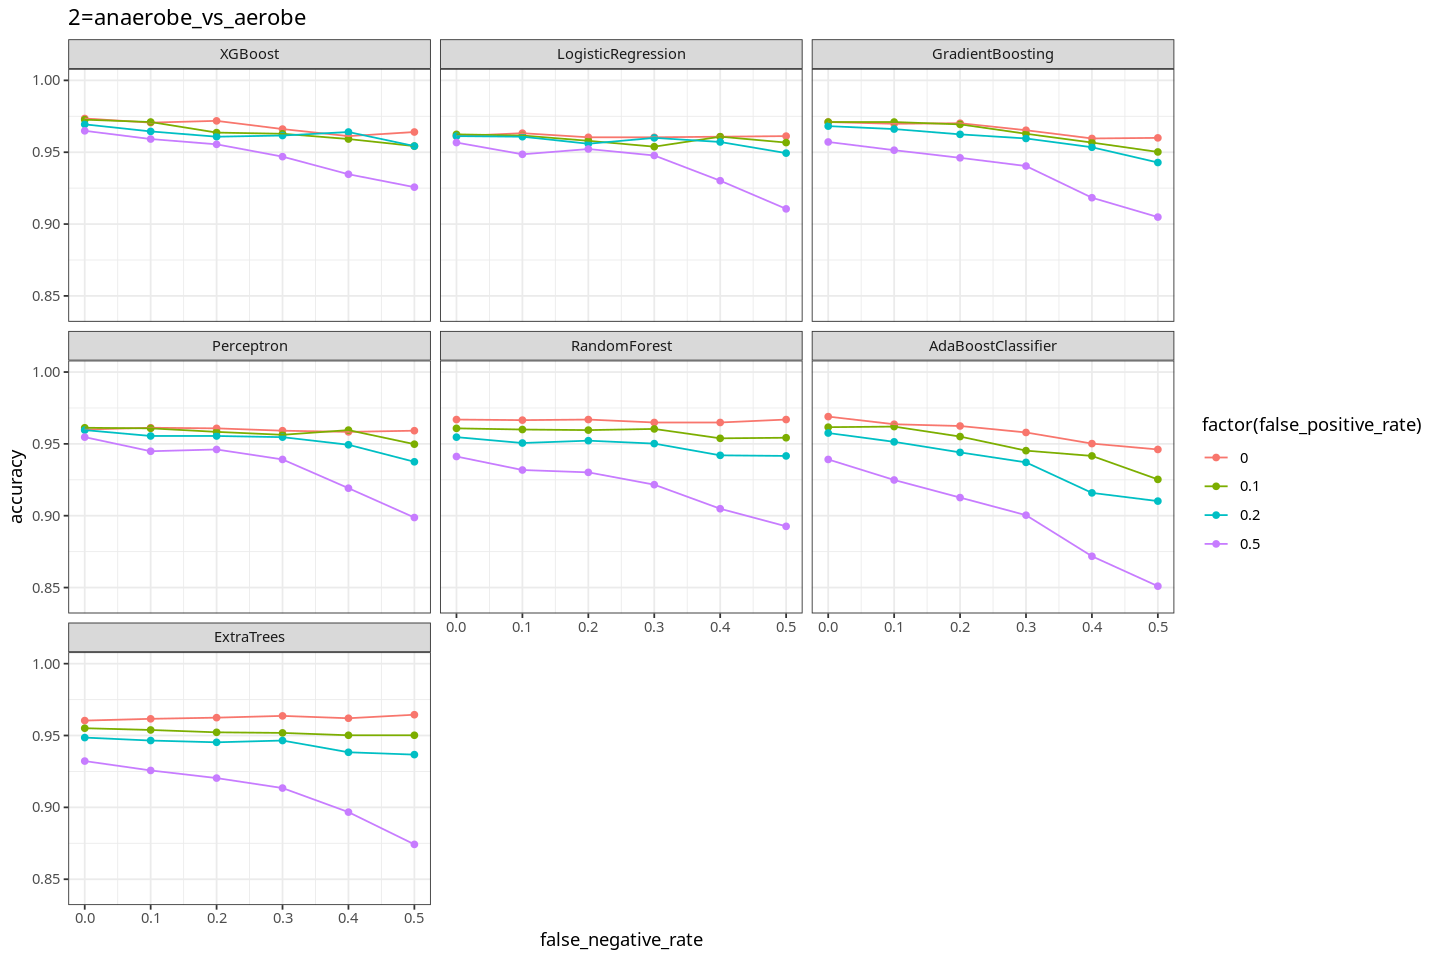

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


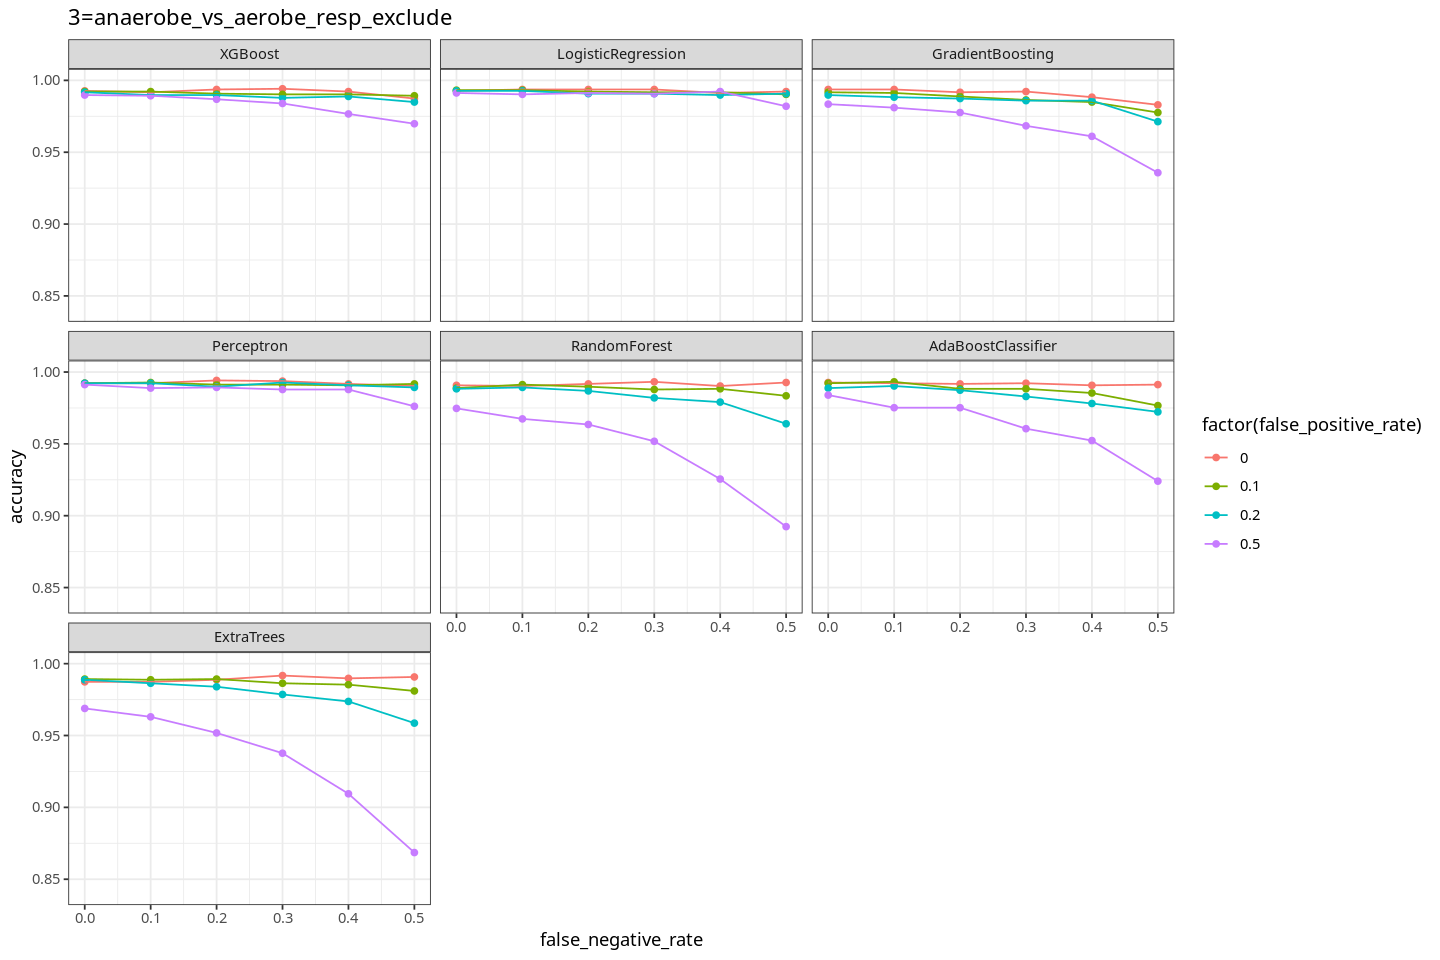

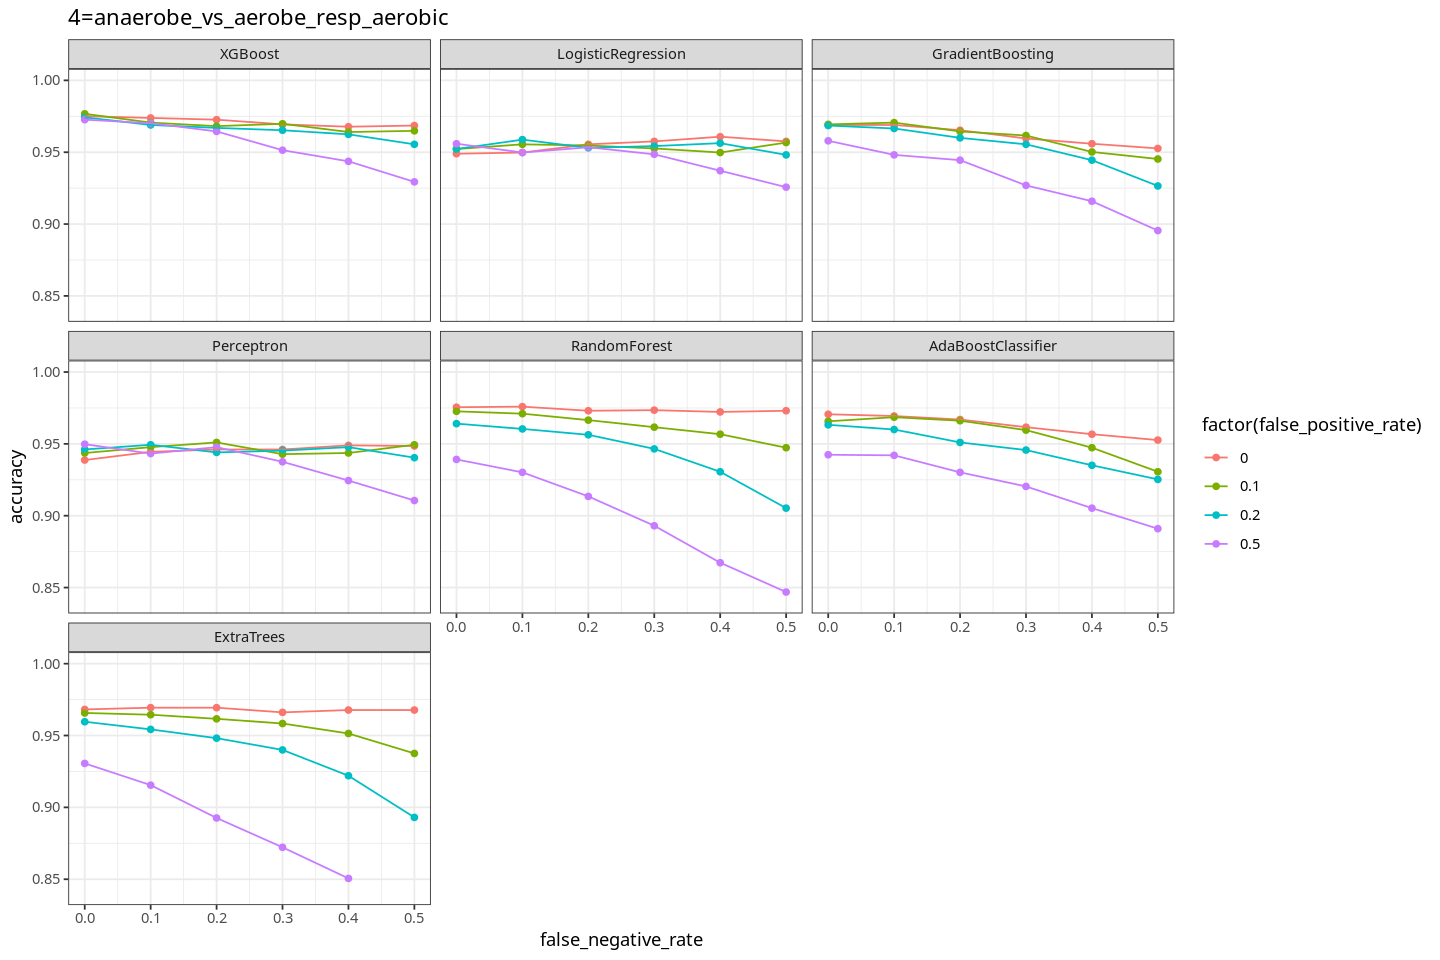

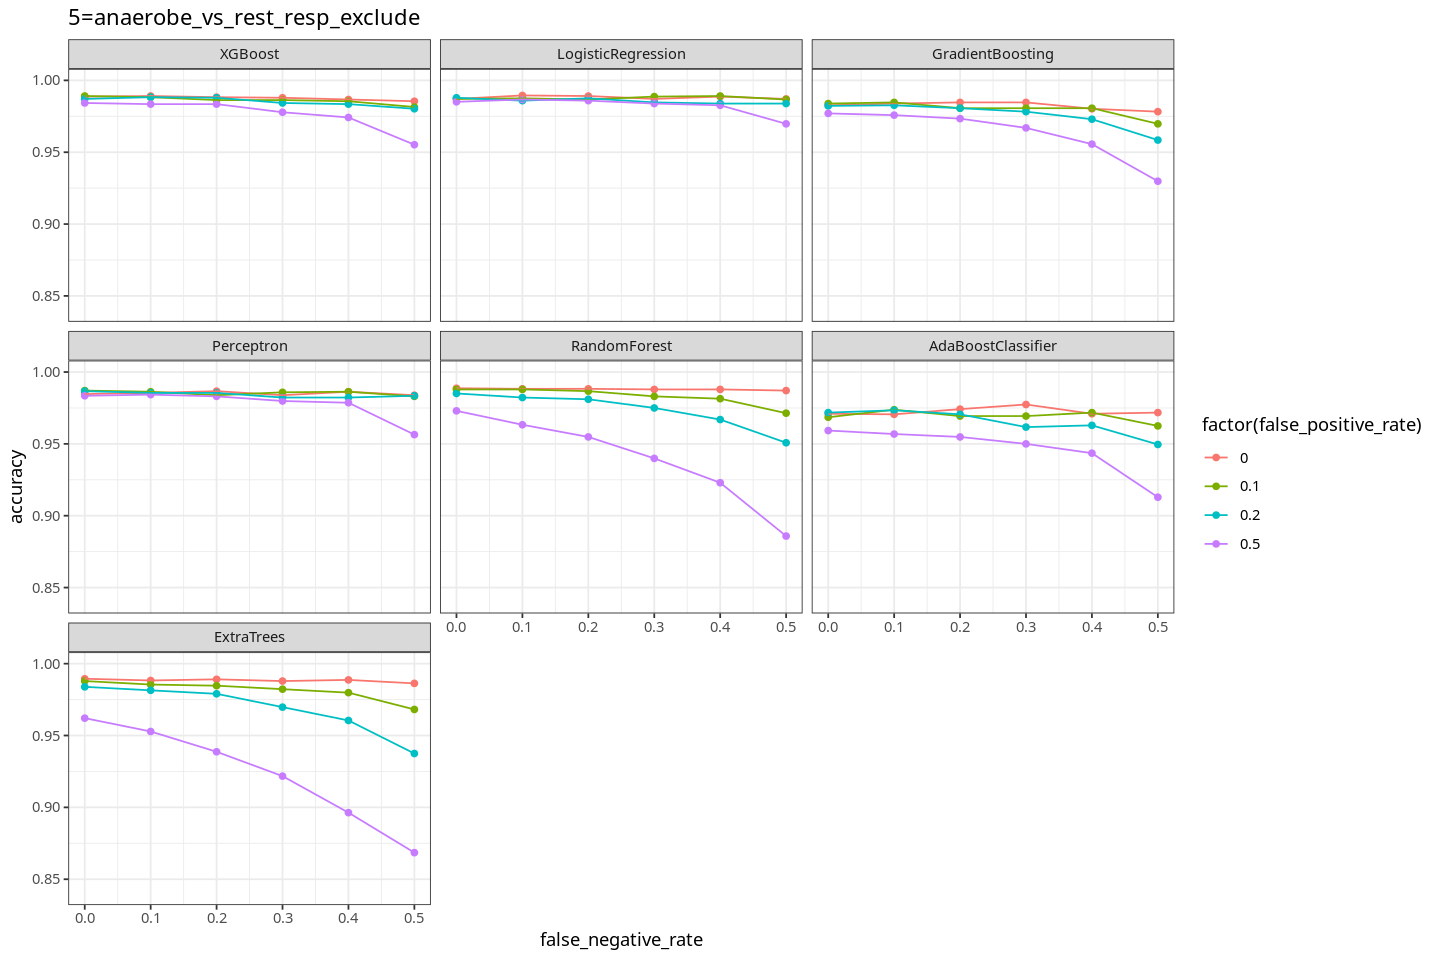

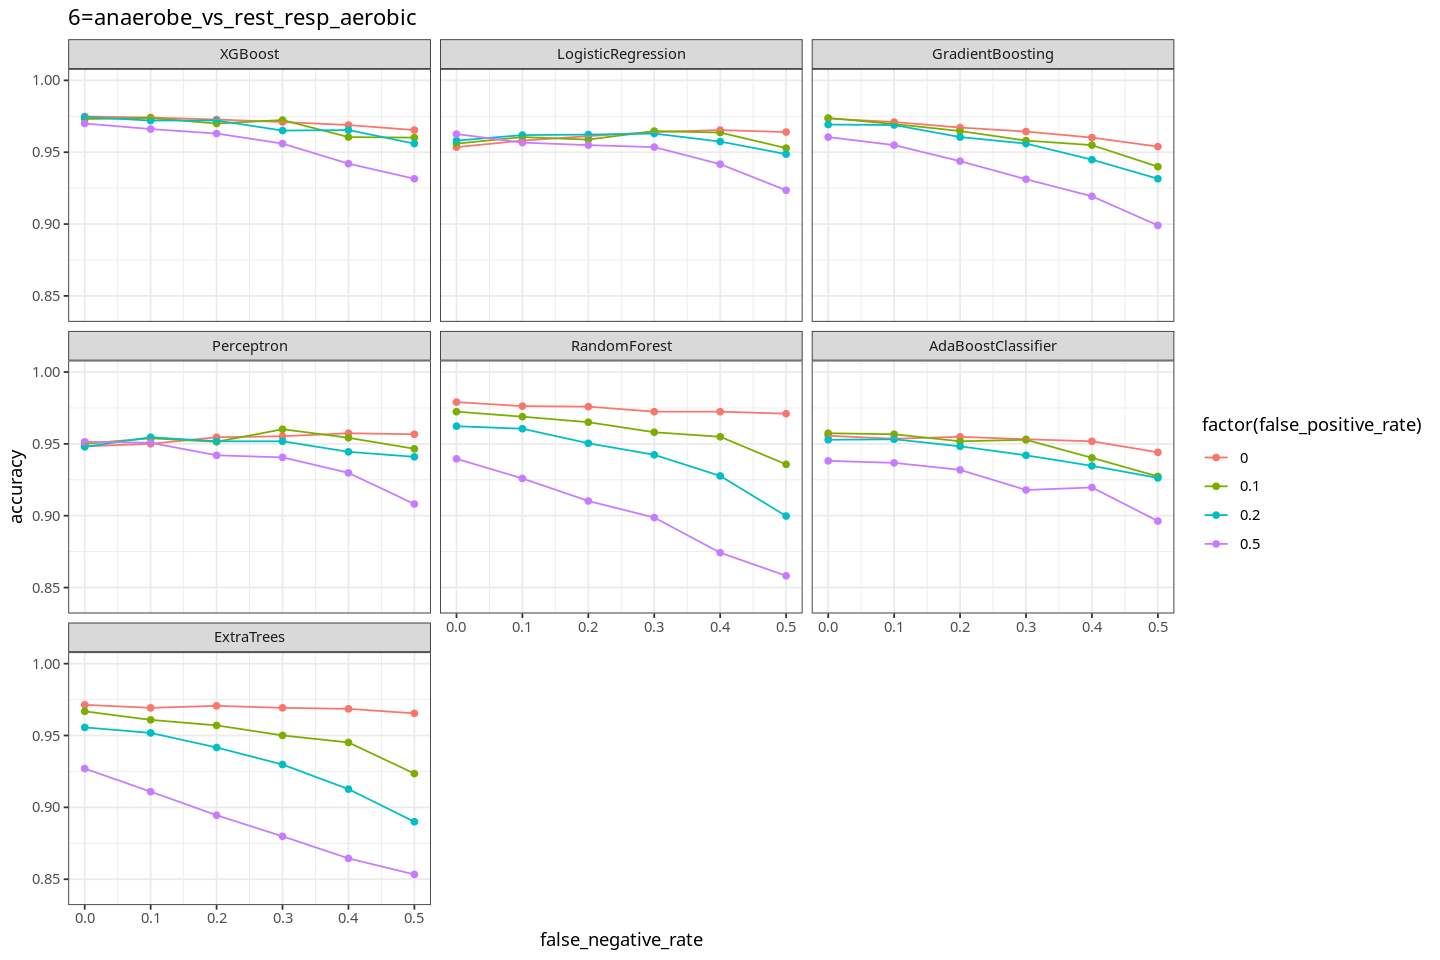

In [13]:
options(repr.plot.width=12, repr.plot.height=8)

for (dataset_name in dataset_names) {
    print(qplot(data=accuracies[dataset==dataset_name][grep('Isotonic',predictor,invert=T)][grep('Sigmoid',predictor,invert=T)][grep('GaussianNB',predictor,invert=T)][false_positive_rate %in% c(0,0.1,0.2,0.5)], false_negative_rate, accuracy, ylim=c(0.84,1), colour=factor(false_positive_rate), main=dataset_name)+geom_line()+facet_wrap(~predictor))
}


In [14]:
dcast(accuracies[grep('Isotonic',predictor,invert=T)][grep('Sigmoid',predictor,invert=T)], dataset~predictor, value.var='accuracy', fun.aggregate=mean)

#=> this data was put into a table in the spreadsheet for colouring

dataset,XGBoost,LogisticRegression,GradientBoosting,Perceptron,RandomForest,AdaBoostClassifier,ExtraTrees,GaussianNB
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,0.9574145,0.9517949,0.9517001,0.9482027,0.9448120,0.9251079,0.9391924,0.8477854
1=anaerobe_vs_rest,0.9495479,0.9348294,0.9413106,0.9172973,0.9316277,0.9182190,0.9258451,0.8179551
2=anaerobe_vs_aerobe,0.9587360,0.9524069,0.9535184,0.9478472,0.9444671,0.9290980,0.9385350,0.8464906
3=anaerobe_vs_aerobe_resp_exclude,0.9878962,0.9910743,0.9799984,0.9897896,0.9729796,0.9782673,0.9667451,0.8543357
4=anaerobe_vs_aerobe_resp_aerobic,0.9640329,0.9509550,0.9486752,0.9417563,0.9362438,0.9421646,0.9262964,0.7893018
5=anaerobe_vs_rest_resp_exclude,0.9829456,0.9849626,0.9731186,0.9820156,0.9659585,0.9614540,0.9588208,0.8277867
6=anaerobe_vs_rest_resp_aerobic,0.9638879,0.9559417,0.9503629,0.9473843,0.9356832,0.9372744,0.9253211,0.7786704


# Prediction probabilities change with calibration? TODO

In [15]:
# d[false_positive_rate==0 & false_negative_rate==0][grep('XGBoost',predictor), .(accession,predictor, prob_aerobe)][accession=='GB_GCA_000252485.1']

In [16]:
# qplot(data=d[grep('XGBoost',predictor)][false_positive_rate %in% c(0) & false_negative_rate %in% c(0,0.5)], prob_aerobe, geom='histogram', binwidth=0.05, )+facet_grid(predictor~false_negative_rate)

In [17]:
# m = dcast(d[false_positive_rate==0 & false_negative_rate==0.5][grep('XGBoost',predictor), .(accession,predictor, prob_aerobe)], accession~predictor, value.var='prob_aerobe')
# m[1:3]
# qplot(data=m, XGBoost, XGBoost_Isotonic, alpha=I(1/10))

# Prediction as a 3-class problem works? UNDER CONSTRUCTION

In [18]:
# Read cv probabities of the 3-class predictions
system('ls -d data/*.cv_data/*csv |grep new_class > data/cv_data_files.txt')
files = fread('data/cv_data_files.txt', header=F)
d1 = files[grep('Perceptron', invert = T, V1),fread(input=V1, header=T, sep='\t', colClasses=list(double='y_actual')), by=V1]
d2 = files[grep('Perceptron', V1),fread(input=V1, header=T, sep='\t', colClasses=list(double=c('y_actual','false_negative_rate','false_positive_rate'))), by=V1]
d2[, prob_anaerobe := -1]
d2[, prob_aerobe := -1]

# hack
d1 = files[grep('XGBoost', V1),fread(input=V1, header=T, sep='\t', colClasses=list(double='y_actual')), by=V1]
d = d1#rbind(d1, d2)
dim(d)
d[1:3]

[1] 88164    10

V1,probability_0,probability_1,probability_2,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor
<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.9616226,1.556686e-06,0.03837589,0,GB_GCA_000010565.1,0,0,0.0,XGBoost
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.9643895,2.110067e-06,0.03560843,0,GB_GCA_000010565.1,0,0,0.1,XGBoost
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.8489321,8.439703e-06,0.15105942,0,GB_GCA_000010565.1,0,0,0.2,XGBoost


In [19]:
d[, dataset := gsub('data/(.+).csv.cv_data/.*', '\\1', V1)]
d[1:3]

V1,probability_0,probability_1,probability_2,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor,dataset
<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.9616226,1.556686e-06,0.03837589,0,GB_GCA_000010565.1,0,0,0.0,XGBoost,bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.9643895,2.110067e-06,0.03560843,0,GB_GCA_000010565.1,0,0,0.1,XGBoost,bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.8489321,8.439703e-06,0.15105942,0,GB_GCA_000010565.1,0,0,0.2,XGBoost,bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class


In [20]:
d[dataset == 'bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class', dataset2 := '7=3_class_problem']
data.table(table(d$dataset2))
d[1:3]

V1,N
<chr>,<int>
7=3_class_problem,88164


V1,probability_0,probability_1,probability_2,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor,dataset,dataset2
<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.9616226,1.556686e-06,0.03837589,0,GB_GCA_000010565.1,0,0,0.0,XGBoost,bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class,7=3_class_problem
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.9643895,2.110067e-06,0.03560843,0,GB_GCA_000010565.1,0,0,0.1,XGBoost,bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class,7=3_class_problem
data/bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class.csv.cv_data/prediction_probabilities_XGBoost_0.csv,0.8489321,8.439703e-06,0.15105942,0,GB_GCA_000010565.1,0,0,0.2,XGBoost,bacdive_scrape_20230315.json.parsed.anaerobe_vs_rest.with_cyanos.apply_respiration_gene_new_class,7=3_class_problem


In [21]:
d[, V1 := NULL]
d[, dataset := NULL]
setnames(d, 'dataset2', 'dataset')
d[1:3]

probability_0,probability_1,probability_2,prediction,accession,y_actual,false_negative_rate,false_positive_rate,predictor,dataset
<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.9616226,1.556686e-06,0.03837589,0,GB_GCA_000010565.1,0,0,0.0,XGBoost,7=3_class_problem
0.9643895,2.110067e-06,0.03560843,0,GB_GCA_000010565.1,0,0,0.1,XGBoost,7=3_class_problem
0.8489321,8.439703e-06,0.15105942,0,GB_GCA_000010565.1,0,0,0.2,XGBoost,7=3_class_problem


In [22]:
accuracies = d[grep('Isotonic',predictor,invert=T)][grep('Sigmoid',predictor,invert=T)][,.(accuracy= mean(prediction==y_actual)), by=list(predictor, false_negative_rate, false_positive_rate, dataset)]
accuracies[1:3]

predictor,false_negative_rate,false_positive_rate,dataset,accuracy
<chr>,<dbl>,<dbl>,<chr>,<dbl>
XGBoost,0,0.0,7=3_class_problem,0.9465088
XGBoost,0,0.1,7=3_class_problem,0.9485504
XGBoost,0,0.2,7=3_class_problem,0.9461004


In [23]:
library(caret)

ERROR: Error in library(caret): there is no package called ‘caret’


In [ ]:
with(d, confusionMatrix(factor(y_actual, levels=c(0,1,2)), factor(prediction, levels=c(0,1,2))))

Confusion Matrix and Statistics

          Reference
Prediction     0     1     2
         0 14301   303   984
         1   220 57229   907
         2  1451  2503 10266

Overall Statistics
                                         
               Accuracy : 0.9278         
                 95% CI : (0.926, 0.9295)
    No Information Rate : 0.6809         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.8541         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.8954   0.9533   0.8445
Specificity            0.9822   0.9599   0.9480
Pos Pred Value         0.9174   0.9807   0.7219
Neg Pred Value         0.9770   0.9059   0.9744
Prevalence             0.1812   0.6809   0.1379
Detection Rate         0.1622   0.6491   0.1164
Detection Prevalence   0.1768   0.6619   0.1613
Balanced Accuracy      0.9

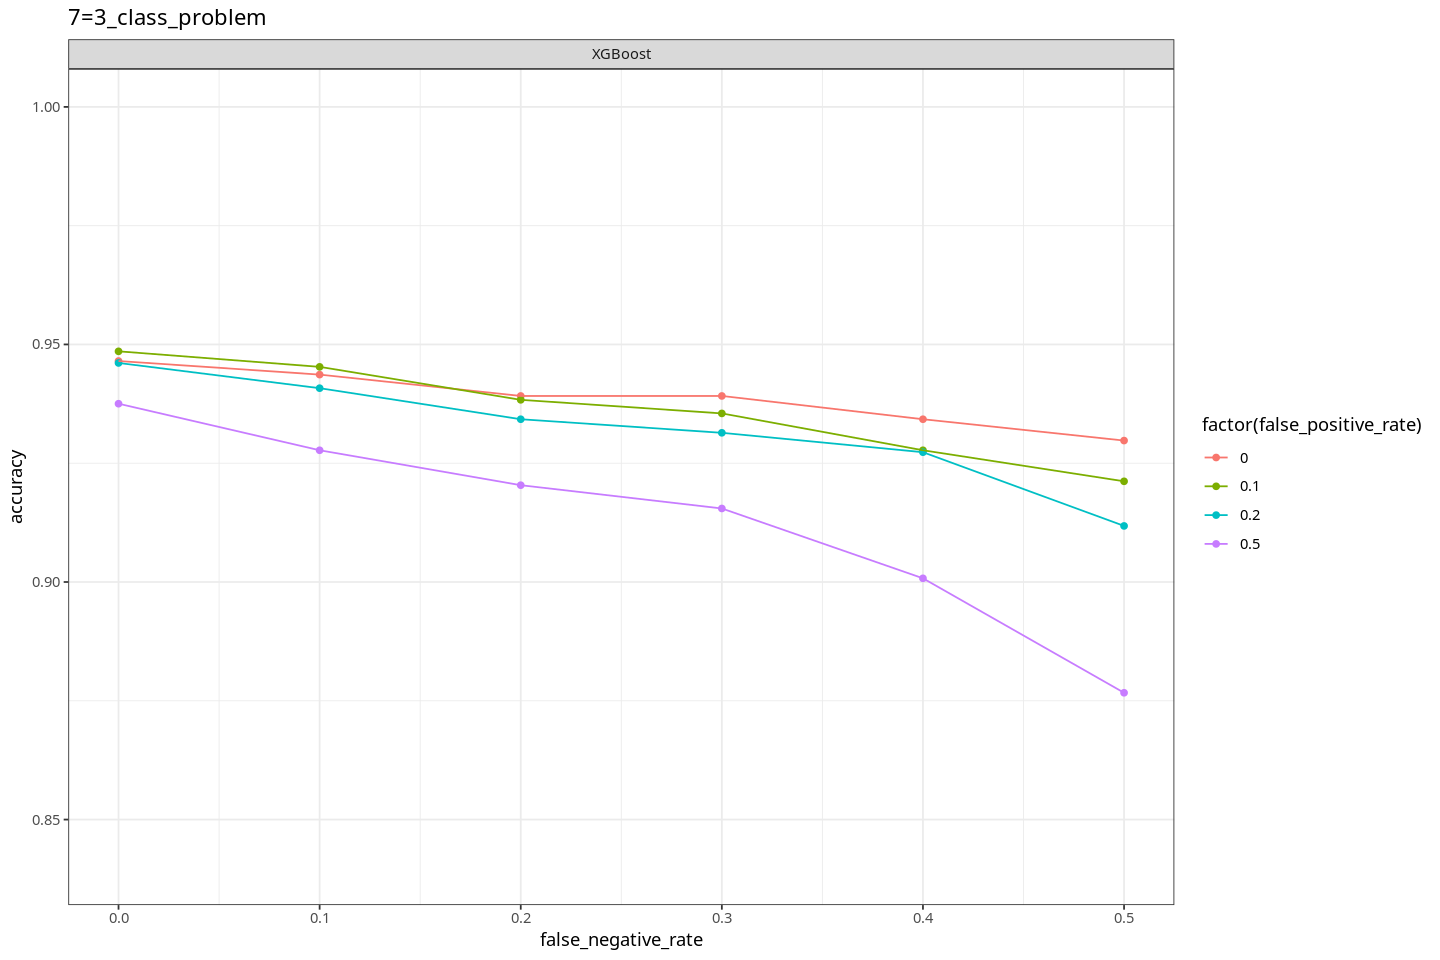

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)

for (dataset_name in '7=3_class_problem') {
    print(qplot(data=accuracies[dataset==dataset_name][grep('Isotonic',predictor,invert=T)][grep('Sigmoid',predictor,invert=T)][grep('GaussianNB',predictor,invert=T)][false_positive_rate %in% c(0,0.1,0.2,0.5)], false_negative_rate, accuracy, ylim=c(0.84,1), colour=factor(false_positive_rate), main=dataset_name)+geom_line()+facet_wrap(~predictor))
}

ERROR: Error in library(cvms): there is no package called ‘cvms’
